In [1]:
from IPython import display
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from scipy.optimize import curve_fit
import glob
import math
import time
import seaborn as sns
from scipy.stats import spearmanr
import gpytorch
%matplotlib notebook
import torch

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 200)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)



## EasyBO method

In [3]:
import sys
PATH = '/home/group/Software/Repos/EasyBO' 
sys.path.append(PATH)
#sys.path.append("../..")
#sys.path.append(PATH)
from easybo import gp
#from easybo.logger import mode
from easybo.logger import logging_mode as mode
from sklearn.model_selection import train_test_split

In [4]:
X_trainb, X_testb, Y_trainb, Y_testb = train_test_split(
    train_x.numpy(), train_y.numpy(), test_size= 0.1, random_state=42
)

print( X_trainb.shape, Y_trainb.shape, X_testb.shape, Y_testb.shape)

(180,) (180,) (20,) (20,)


<IPython.core.display.Javascript object>


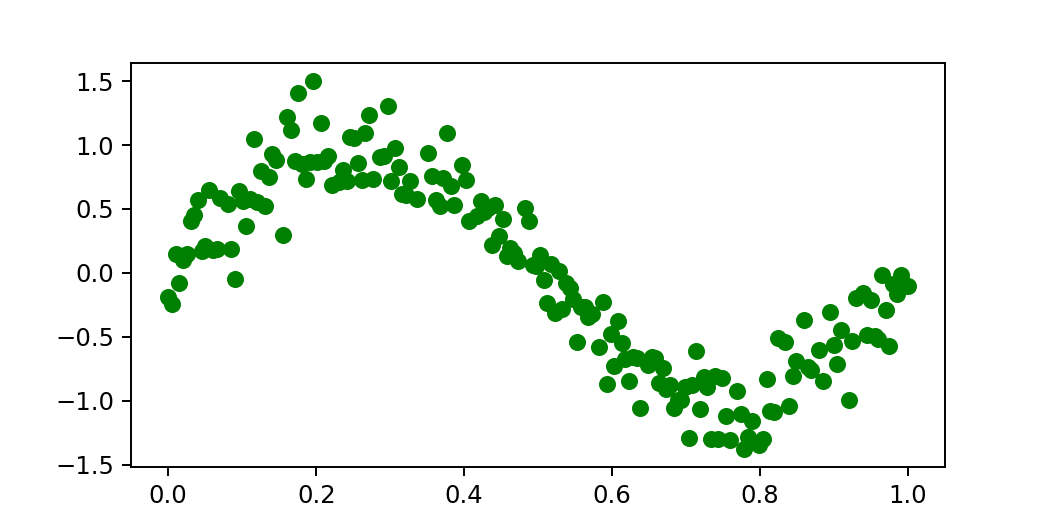

In [5]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_subplot(111)  
ax.plot(X_trainb, Y_trainb, 'go')

In [6]:
# modelH = gp.EasySingleTaskGPRegressor(train_x=X_trainb, train_y=Y_trainb[:, 1].reshape(-1, 1),                                     
#                                      normalize_inputs_to_unity= False,         
#       mean_module=gpytorch.means.ConstantMean(),
#       covar_module=gpytorch.kernels.ScaleKernel( 
#           gpytorch.kernels.MaternKernel(ard_num_dims=3) )
#                                      )


In [7]:
modelH = gp.EasySingleTaskGPRegressor(train_x=X_trainb.reshape(-1, 1), train_y=Y_trainb.reshape(-1, 1),                                     
                                     normalize_inputs_to_unity= False,         
      mean_module=gpytorch.means.ConstantMean(),
      covar_module=gpytorch.kernels.ScaleKernel( gpytorch.kernels.RBFKernel( ) ),                                       
                                     )


In [8]:
with mode(debug=True):
    modelH.train_(   )

DEBUG    (2022-12-05 09:56:53 easybo.gp:train_:296) ------- PARAMETER INFO BEFORE TRAINING -------
DEBUG    (2022-12-05 09:56:53 easybo.gp:_log_training_debug_information:224) likelihood.noise_covar.raw_noise: tensor([0.], requires_grad=True)
DEBUG    (2022-12-05 09:56:53 easybo.gp:_log_training_debug_information:224) mean_module.raw_constant: tensor(0., requires_grad=True)
DEBUG    (2022-12-05 09:56:53 easybo.gp:_log_training_debug_information:224) covar_module.raw_outputscale: tensor(0., requires_grad=True)
DEBUG    (2022-12-05 09:56:53 easybo.gp:_log_training_debug_information:224) covar_module.base_kernel.raw_lengthscale: tensor([[0.]], requires_grad=True)
DEBUG    (2022-12-05 09:56:53 easybo.gp:_log_training_debug_information:230) OUT TRANSFORM: OrderedDict([('means', tensor([[-0.0129]])), ('stdvs', tensor([[0.7294]])), ('_stdvs_sq', tensor([[0.5320]]))])
DEBUG    (2022-12-05 09:56:53 easybo.gp:train_:327) ------- PARAMETER INFO AFTER TRAINING -------
DEBUG    (2022-12-05 09:56:53

In [9]:
y_test_predsH = modelH.predict(grid=X_testb)

In [10]:
spearmanr(y_test_predsH["mean"] , Y_testb)

SpearmanrResult(correlation=0.9383458646616539, pvalue=9.762241109318019e-10)

In [11]:
np.sqrt(np.average( (y_test_predsH["mean"] - Y_testb)**2 ))

0.17288590961950603

In [12]:
y_test_predsH.keys()

dict_keys(['mean', 'std', 'mean+2std', 'mean-2std', 'posterior'])

<IPython.core.display.Javascript object>


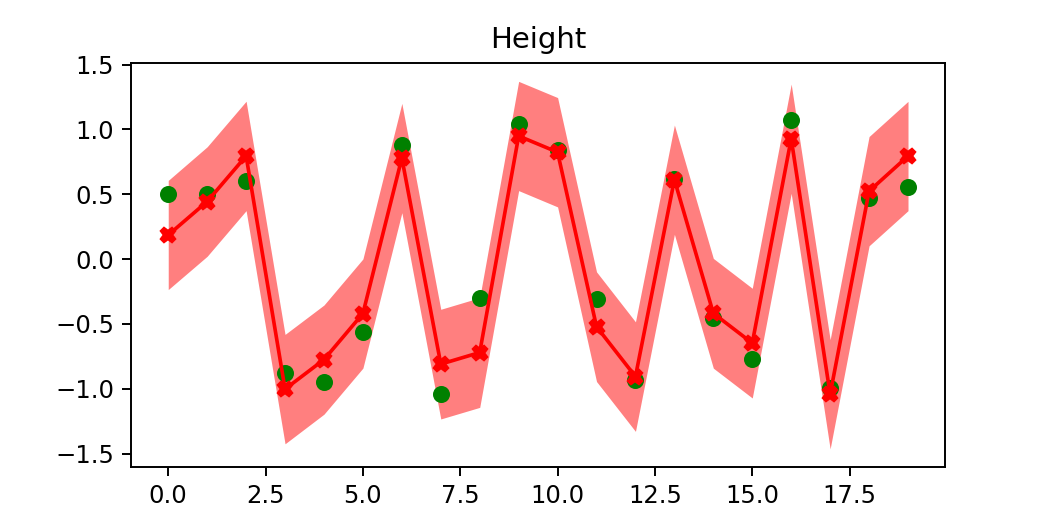

Text(0.5, 1.0, 'Height')

In [14]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_subplot(111) 
grid = [ii for ii in range(len(Y_testb))]
ax.plot(grid, Y_testb, 'go')
ax.plot(grid, y_test_predsH["mean"], "rX-")
ax.fill_between(grid, y_test_predsH['mean-2std'], y_test_predsH['mean+2std'], color="red", alpha=0.5, linewidth=0)

# ax.fill_between(grid, y_test_predsH["mean"]-4*y_test_predsH["std"], 
#                 y_test_predsH["mean"]+4*y_test_predsH["std"], 
#                  color="c", alpha=0.5, linewidth=0)


ax.set_title('Height')

## GPytorch method

In [15]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

#list(likelihood.hyperparameters()), list( model.hyperparameters() )

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr =  .1 )  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    
training_iter = 50

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i%10==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()
    
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

Iter 1/50 - Loss: 0.908   lengthscale: 0.693   noise: 0.693
Iter 11/50 - Loss: 0.465   lengthscale: 0.318   noise: 0.310
Iter 21/50 - Loss: 0.123   lengthscale: 0.211   noise: 0.123
Iter 31/50 - Loss: -0.077   lengthscale: 0.238   noise: 0.050
Iter 41/50 - Loss: -0.066   lengthscale: 0.277   noise: 0.032


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [16]:
test_x = torch.tensor(X_testb)
test_y = torch.tensor(Y_testb)
observed_pred = likelihood(model(test_x)) 
y_mean = observed_pred.mean
y_var = observed_pred.stddev #[ ym - 2*std, ym + 2* std ]

In [17]:
np.sqrt(np.average( (( y_mean - test_y).detach().numpy())**2 ))

0.17145404629724528

<IPython.core.display.Javascript object>


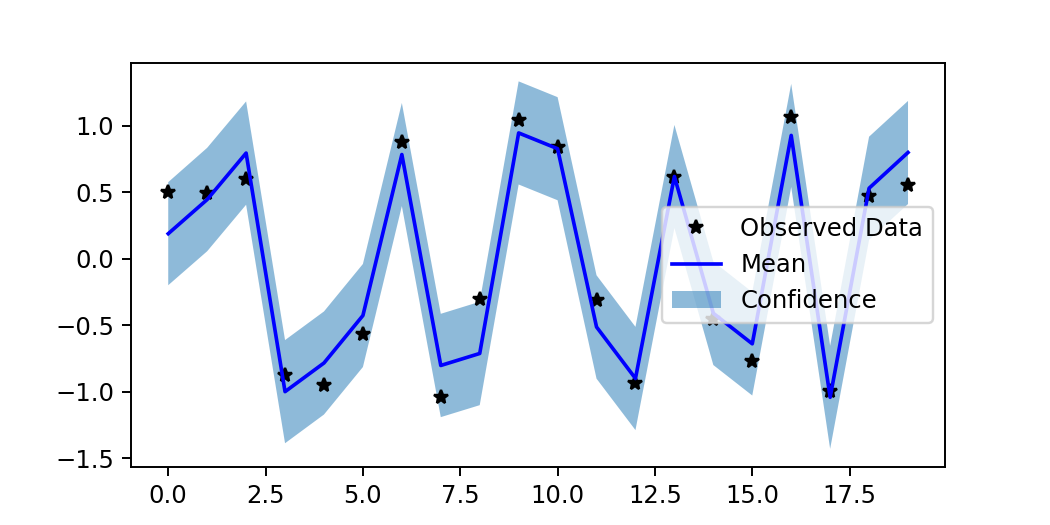

In [18]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))
# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Plot training data as black stars
ax.plot(grid, test_y.numpy(), 'k*')
# Plot predictive means as blue line
ax.plot(grid, (y_mean).detach().numpy(), 'b')

ax.fill_between(grid, lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
#ax.fill_between(grid, (y_mean - 2*y_var).detach().numpy(),   (y_mean + 2*y_var).detach().numpy(),   alpha=.8)

#ax.set_ylim([-1, 1])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Overlay the two methods

<IPython.core.display.Javascript object>


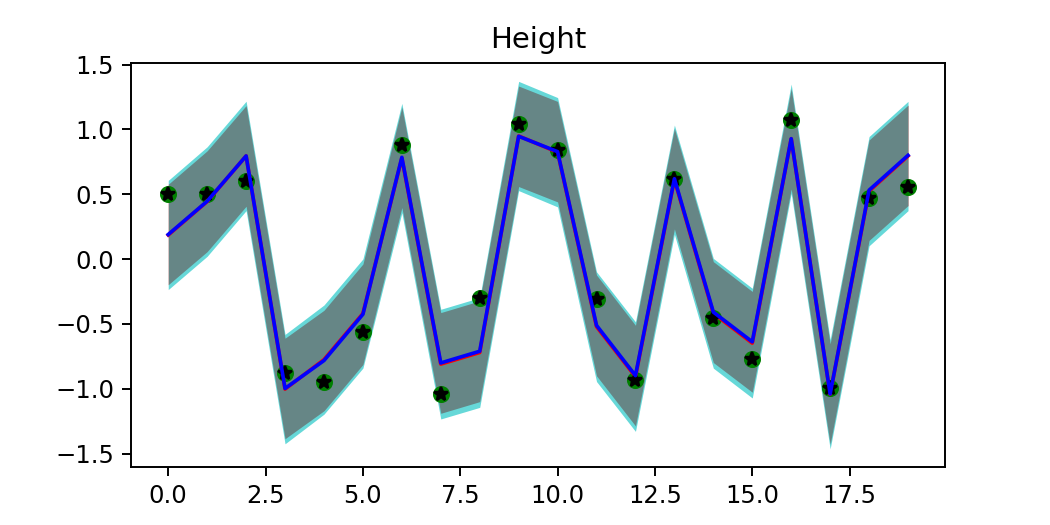

Text(0.5, 1.0, 'Height')

In [19]:
fig = plt.figure(figsize=[6,3])
ax = fig.add_subplot(111) 
grid = [ii for ii in range(len(Y_testb))]
ax.plot(grid, Y_testb, 'go')
ax.plot(grid, y_test_predsH["mean"], "r-")

ax.fill_between(grid,  lower.detach().numpy(), upper.detach().numpy(),
                color="red", alpha=0.8, linewidth=0)

ax.fill_between(grid, y_test_predsH["mean"]-2*y_test_predsH["std"], 
                y_test_predsH["mean"]+2*y_test_predsH["std"], 
                 color="c", alpha=0.6, linewidth=0)


# Plot training data as black stars
ax.plot(grid, test_y.numpy(), 'k*')
# Plot predictive means as blue line
ax.plot(grid, (y_mean).detach().numpy(), 'b')



ax.set_title('Height')




In [23]:
1*y_test_predsH["std"]

array([0.21047083, 0.2110825 , 0.21091297, 0.21086162, 0.21044254,
       0.21040719, 0.21077415, 0.21142975, 0.21151134, 0.21060215,
       0.21078107, 0.21144051, 0.21121192, 0.21068468, 0.21158161,
       0.21150401, 0.21070343, 0.2106481 , 0.21062829, 0.21077805])

In [21]:
y_var 

tensor([0.1937, 0.1943, 0.1941, 0.1938, 0.1937, 0.1936, 0.1937, 0.1942, 0.1942,
        0.1938, 0.1937, 0.1943, 0.1940, 0.1937, 0.1945, 0.1942, 0.1937, 0.1937,
        0.1936, 0.1937], grad_fn=<SqrtBackward0>)

# The END!